# Import relevant libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import bokeh
from bokeh.io import output_file
from bokeh.palettes import Spectral6
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, show
from bokeh.transform import linear_cmap
from bokeh.models.widgets import Tabs, Panel

# Setup

In [2]:
# disable false positive warnings
pd.options.mode.chained_assignment = None

In [3]:
# set file path
base_path = '../..'

uk = pd.read_csv(os.path.join(base_path, 'datasets', 'uk_plotting_data.csv'))

tech_coord = pd.read_csv(
    os.path.join(base_path, 'datasets', 'tech_roundabout_merge.csv'))

clean_data = pd.read_csv(
    os.path.join(base_path, 'datasets', 'industry_added_cleaned_data.csv'))

In [4]:
# merge tech coord and clean_data
all_data = clean_data.merge(tech_coord, how='left', on='CompanyName')

# Data Organization: Impact Events, Time Period Function

## Specific Date Cummulative Count Function

In [5]:
# This function finds specific industry count values by year


def year_cumm_counts(year):

    # slice the data until pre-specified year
    active_df = all_data[all_data['year'] <= year]

    # sort values by 'year', 'month'
    active_df.sort_values(by='year', inplace=True)

    # reset index
    active_df.reset_index(drop=True, inplace=True)

    # get the index of the last month we want
    idx = active_df[active_df['year'] == year].index[-1] + 1

    # slice dataframe
    active_df = active_df.iloc[:idx]

    # group data
    active_df = pd.DataFrame(
        active_df.groupby('sector_name_1')['count'].agg('sum'))

    # reset index
    active_df.reset_index(inplace=True)

    return active_df

## Use Function to iterate ever year, month get values by sector

In [6]:
# iteration variables
a = np.arange(1991, 2021, 1)

In [7]:
# trying to create a master Data frame with all year month values show groupedby industry counts
tw = []

for i in a:
    year_dict = year_cumm_counts(i)
    year_dict['year'] = i
    tw.append(year_dict.to_dict('records'))

In [8]:
# create seperate lists for section of list

ind = []
ct = []
year = []

for i in tw:
    for j in i:
        ind.append(j['sector_name_1'])
        ct.append(j['count'])
        year.append(j['year'])

In [9]:
# create new dataframe with all lists in each section (used to create pivot table below)

cool_df = pd.DataFrame()

cool_df['sector_name_1'] = ind
cool_df['count'] = ct
cool_df['year'] = year

In [10]:
# groupby
cool_df = pd.DataFrame(
    cool_df.groupby(['year', 'sector_name_1'])['count'].agg('sum'))
cool_df.reset_index(inplace=True)

## Export Pivot Data for Horizontal Bar Chart

In [11]:
# pivot table for our horizonatal bar chart
pivot = pd.pivot_table(cool_df,
                       values='count',
                       index='year',
                       columns='sector_name_1',
                       fill_value=0)
pivot.reset_index(inplace=True)

In [12]:
# save pivot data as csv
save_path = os.path.join(base_path, 'datasets',
                         'pivot_table_year_cumcount.csv')
pivot.to_csv(save_path, index=False)

# Impactful Event Visualisations

## Dynamic Lolipop Chart By Event and Sector

In [13]:
"""
Insert Date into year_cumm_counts function to get different events
"""

# dotocom bubble
dtb_before = year_cumm_counts(1995)
dtb_after = year_cumm_counts(2000)

# The Great Recession
tgr_before = year_cumm_counts(2007)
tgr_after = year_cumm_counts(2011)

# Tech initiatives "Tech City" by PM
ti_before = year_cumm_counts(2010)
ti_after = year_cumm_counts(2014)

# Future Fifity
ff_before = year_cumm_counts(2013)
ff_after = year_cumm_counts(2015)

# brexit
brex_before = year_cumm_counts(2016)
brex_after = year_cumm_counts(2018)

# Entrepreneur Visa discontinued
ev_before = year_cumm_counts(2019)
ev_after = year_cumm_counts(2020)

# Companies act
ca_before = year_cumm_counts(2006)
ca_after = year_cumm_counts(2008)

In [14]:
"""
Find company growth during an event (between two time periods) normal
"""


def events_data(after, before):

    # merge after and before
    total = after.merge(before, how='left', on='sector_name_1')

    # replace NA with after value because NA results from 0 before
    total['count_y'] = total['count_y'].fillna(0)

    # find difference
    diff = total['count_x'] - total['count_y']

    # get data frame
    diff = pd.DataFrame(diff)
    diff['sector_name_1'] = after['sector_name_1']
    diff['before_count'] = before['count']
    diff['after_count'] = after['count']
    diff['before_count'] = diff['before_count'].fillna(0)
    diff.columns = ['count', 'sector_name_1', 'before_count', 'after_count']
    diff['pct'] = diff['count'] / diff['before_count'] * 100
    diff['count'] = pd.to_numeric(diff['count'], downcast='integer')
    diff['before_count'] = pd.to_numeric(diff['before_count'],
                                         downcast='integer')

    return diff

In [15]:
dotcom_bubble = events_data(dtb_after, dtb_before)
great_recession = events_data(tgr_after, tgr_before)
tech_city = events_data(ti_after, ti_before)
future_fifty = events_data(ff_after, ff_before)
brexit = events_data(brex_after, brex_before)
e_visa = events_data(ev_after, ev_before)
uk_companies_act = events_data(ca_after, ca_before)

In [16]:
# use norm_plt for chart and use before for the hover attribute
dotcom_bubble.reset_index(inplace=True)
great_recession.reset_index(inplace=True)
tech_city.reset_index(inplace=True)
future_fifty.reset_index(inplace=True)
brexit.reset_index(inplace=True)
e_visa.reset_index(inplace=True)
uk_companies_act.reset_index(inplace=True)

In [17]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
rc('text', usetex=True)

dotcom_bubble_event = ColumnDataSource(dotcom_bubble)
great_recession_event = ColumnDataSource(great_recession)
tech_city_event = ColumnDataSource(tech_city)
future_fifty_event = ColumnDataSource(future_fifty)
brexit_event = ColumnDataSource(brexit)
e_visa_event = ColumnDataSource(e_visa)
uk_companies_act_event = ColumnDataSource(uk_companies_act)

plot_size_and_tools = {
    'plot_height': 400,
    'plot_width': 800,
    'tools': ['box_select', 'reset', 'help']
}
y = [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
mapper = linear_cmap(field_name='count',
                     palette=Spectral6,
                     low=min(y),
                     high=max(y))

# dotcom bubble
p1 = figure(title="Dotcom Bubble growth effects on Tech City",
            **plot_size_and_tools)
p1.segment(
    'index',
    0,
    'index',
    'count',
    source=dotcom_bubble_event,
    line_width=2,
    line_color="green",
)
p1.circle(x='index',
          y='count',
          source=dotcom_bubble_event,
          color=mapper,
          alpha=0.7,
          size=10)
tab1 = Panel(child=p1, title="Dotcom Bubble")
p1.xaxis.major_label_overrides = {
    0: 'Biotech Rsrch.',
    1: 'Business Software Dev.',
    2: 'Computer Game Companies',
    3: 'Computer facilities mgmt.',
    4: 'Data Companies',
    5: 'Fund management activities',
    6: 'Info Tech Consulting',
    7: 'Info Tech services',
    8: 'Natural Sciences Rsrch.',
    9: 'Open-ended Investors',
    10: 'Satellite Telecommuncations',
    11: 'Social Sciences Rsrch.',
    12: 'Software Dev.',
    13: 'Technical testing and analysis',
    14: 'Venture Capital',
    15: 'Web portals',
    16: 'Wireless Telecommuncations'
}
p1.xaxis.major_label_orientation = "vertical"
p1.xaxis.ticker = list(range(0, 17))
p1.xgrid.grid_line_color = None
p1.ygrid.band_fill_alpha = 0.1
p1.ygrid.band_fill_color = "lightgrey"
hover = HoverTool(tooltips=[('Pct Change', '@pct%')])
p1.add_tools(hover)

# great recession
p2 = figure(title="The Great Recession effects on Tech City Sectors",
            x_range=p1.x_range,
            y_range=p1.y_range,
            **plot_size_and_tools)
p2.segment(
    'index',
    0,
    'index',
    'count',
    source=great_recession_event,
    line_width=2,
    line_color="green",
)
p2.circle(x='index',
          y='count',
          source=great_recession_event,
          color=mapper,
          size=10,
          alpha=0.9)
tab2 = Panel(child=p2, title="The Great Recession")
p2.xaxis.major_label_overrides = {
    0: 'Biotech Rsrch.',
    1: 'Business Software Dev.',
    2: 'Computer Game Companies',
    3: 'Computer facilities mgmt.',
    4: 'Data Companies',
    5: 'Fund management activities',
    6: 'Info Tech Consulting',
    7: 'Info Tech services',
    8: 'Natural Sciences Rsrch.',
    9: 'Open-ended Investors',
    10: 'Satellite Telecommuncations',
    11: 'Social Sciences Rsrch.',
    12: 'Software Dev.',
    13: 'Technical testing and analysis',
    14: 'Venture Capital',
    15: 'Web portals',
    16: 'Wireless Telecommuncations'
}
p2.xaxis.major_label_orientation = "vertical"
p2.xaxis.ticker = list(range(0, 17))
p2.xgrid.grid_line_color = None
p2.ygrid.band_fill_color = "lightgrey"
hover = HoverTool(tooltips=[('Pct Change', '@pct%')])
p2.add_tools(hover)

p3 = figure(title="Tech City Initiatives effects on Tech City Sectors",
            x_range=p1.x_range,
            y_range=p1.y_range,
            **plot_size_and_tools)
p3.segment(
    'index',
    0,
    'index',
    'count',
    source=tech_city_event,
    line_width=2,
    line_color="green",
)
p3.circle(x='index',
          y='count',
          source=tech_city_event,
          color=mapper,
          size=10,
          alpha=0.9)
tab3 = Panel(child=p3, title="Tech City Initiatives")
p3.xaxis.major_label_overrides = {
    0: 'Biotech Rsrch.',
    1: 'Business Software Dev.',
    2: 'Computer Game Companies',
    3: 'Computer facilities mgmt.',
    4: 'Data Companies',
    5: 'Fund management activities',
    6: 'Info Tech Consulting',
    7: 'Info Tech services',
    8: 'Natural Sciences Rsrch.',
    9: 'Open-ended Investors',
    10: 'Satellite Telecommuncations',
    11: 'Social Sciences Rsrch.',
    12: 'Software Dev.',
    13: 'Technical testing and analysis',
    14: 'Venture Capital',
    15: 'Web portals',
    16: 'Wireless Telecommuncations'
}
p3.xaxis.major_label_orientation = "vertical"
p3.xaxis.ticker = list(range(0, 17))
p3.xgrid.grid_line_color = None
p3.ygrid.band_fill_color = "lightgrey"
hover = HoverTool(tooltips=[('Pct Change', '@pct%')])
p3.add_tools(hover)

p4 = figure(title="Future Fifty effects on Tech City Sectors",
            **plot_size_and_tools)
p4.segment(
    'index',
    0,
    'index',
    'count',
    source=future_fifty_event,
    line_width=2,
    line_color="green",
)
p4.circle(x='index',
          y='count',
          source=future_fifty_event,
          color=mapper,
          alpha=0.7,
          size=10)
tab4 = Panel(child=p4, title="Future Fifty")
p4.xaxis.major_label_overrides = {
    0: 'Biotech Rsrch.',
    1: 'Business Software Dev.',
    2: 'Computer Game Companies',
    3: 'Computer facilities mgmt.',
    4: 'Data Companies',
    5: 'Fund management activities',
    6: 'Info Tech Consulting',
    7: 'Info Tech services',
    8: 'Natural Sciences Rsrch.',
    9: 'Open-ended Investors',
    10: 'Satellite Telecommuncations',
    11: 'Social Sciences Rsrch.',
    12: 'Software Dev.',
    13: 'Technical testing and analysis',
    14: 'Venture Capital',
    15: 'Web portals',
    16: 'Wireless Telecommuncations'
}
p4.xaxis.major_label_orientation = "vertical"
p4.xaxis.ticker = list(range(0, 17))
p4.xgrid.grid_line_color = None
p4.ygrid.band_fill_alpha = 0.1
p4.ygrid.band_fill_color = "lightgrey"
hover = HoverTool(tooltips=[('Pct Change', '@pct%')])
p4.add_tools(hover)

p5 = figure(title="brexit effects on Tech City", **plot_size_and_tools)
p5.segment(
    'index',
    0,
    'index',
    'count',
    source=brexit_event,
    line_width=2,
    line_color="green",
)
p5.circle(x='index',
          y='count',
          source=brexit_event,
          color=mapper,
          alpha=0.7,
          size=10)
tab5 = Panel(child=p5, title="brexit")
p5.xaxis.major_label_overrides = {
    0: 'Biotech Rsrch.',
    1: 'Business Software Dev.',
    2: 'Computer Game Companies',
    3: 'Computer facilities mgmt.',
    4: 'Data Companies',
    5: 'Fund management activities',
    6: 'Info Tech Consulting',
    7: 'Info Tech services',
    8: 'Natural Sciences Rsrch.',
    9: 'Open-ended Investors',
    10: 'Satellite Telecommuncations',
    11: 'Social Sciences Rsrch.',
    12: 'Software Dev.',
    13: 'Technical testing and analysis',
    14: 'Venture Capital',
    15: 'Web portals',
    16: 'Wireless Telecommuncations'
}
p5.xaxis.major_label_orientation = "vertical"
p5.xaxis.ticker = list(range(0, 17))
p5.xgrid.grid_line_color = None
p5.ygrid.band_fill_alpha = 0.1
p5.ygrid.band_fill_color = "lightgrey"
hover = HoverTool(tooltips=[('Pct Change', '@pct%')])
p5.add_tools(hover)

p6 = figure(
    title="Discontinuation of Entrepreneurship Visa effect on Tech City",
    **plot_size_and_tools)
p6.segment(
    'index',
    0,
    'index',
    'count',
    source=e_visa_event,
    line_width=2,
    line_color="green",
)
p6.circle(x='index',
          y='count',
          source=e_visa_event,
          color=mapper,
          alpha=0.7,
          size=10)
tab6 = Panel(child=p6, title="Discontinuation of Entrepreneurship visa")
p6.xaxis.major_label_overrides = {
    0: 'Biotech Rsrch.',
    1: 'Business Software Dev.',
    2: 'Computer Game Companies',
    3: 'Computer facilities mgmt.',
    4: 'Data Companies',
    5: 'Fund management activities',
    6: 'Info Tech Consulting',
    7: 'Info Tech services',
    8: 'Natural Sciences Rsrch.',
    9: 'Open-ended Investors',
    10: 'Satellite Telecommuncations',
    11: 'Social Sciences Rsrch.',
    12: 'Software Dev.',
    13: 'Technical testing and analysis',
    14: 'Venture Capital',
    15: 'Web portals',
    16: 'Wireless Telecommuncations'
}
p6.xaxis.major_label_orientation = "vertical"
p6.xaxis.ticker = list(range(0, 17))
p6.xgrid.grid_line_color = None
p6.ygrid.band_fill_alpha = 0.1
p6.ygrid.band_fill_color = "lightgrey"
hover = HoverTool(tooltips=[('Pct Change', '@pct%')])
p6.add_tools(hover)

p7 = figure(title="UK Comanies Act effect on Tech City", **plot_size_and_tools)
p7.segment(
    'index',
    0,
    'index',
    'count',
    source=uk_companies_act_event,
    line_width=2,
    line_color="green",
)
p7.circle(x='index',
          y='count',
          source=uk_companies_act_event,
          color=mapper,
          alpha=0.7,
          size=10)
tab7 = Panel(child=p7, title="UK Companies Act")
p7.xaxis.major_label_overrides = {
    0: 'Biotech Rsrch.',
    1: 'Business Software Dev.',
    2: 'Computer Game Companies',
    3: 'Computer facilities mgmt.',
    4: 'Data Companies',
    5: 'Fund management activities',
    6: 'Info Tech Consulting',
    7: 'Info Tech services',
    8: 'Natural Sciences Rsrch.',
    9: 'Open-ended Investors',
    10: 'Satellite Telecommuncations',
    11: 'Social Sciences Rsrch.',
    12: 'Software Dev.',
    13: 'Technical testing and analysis',
    14: 'Venture Capital',
    15: 'Web portals',
    16: 'Wireless Telecommuncations'
}
p7.xaxis.major_label_orientation = "vertical"
p7.xaxis.ticker = list(range(0, 17))
p7.xgrid.grid_line_color = None
p7.ygrid.band_fill_alpha = 0.1
p7.ygrid.band_fill_color = "lightgrey"
hover = HoverTool(tooltips=[('Pct Change', '@pct%')])
p7.add_tools(hover)

# save as html
file_path = os.path.join('output', 'lollipop_event_chart.html')
output_file(file_path)
print(f"The html file is saved to {file_path}")

show(Tabs(tabs=[tab1, tab7, tab2, tab3, tab4, tab5, tab6]))

The html file is saved to output/lollipop_event_chart.html


## Even Supporting Chart: Heatmap of Events and Sectors

In [18]:
# create data frames for events

dotcom_bubble = events_data(dtb_after, dtb_before)
great_recession = events_data(tgr_after, tgr_before)
tech_city = events_data(ti_after, ti_before)
future_fifty = events_data(ff_after, ff_before)
brexit = events_data(brex_after, brex_before)
e_visa = events_data(ev_after, ev_before)
uk_companies_act = events_data(ca_after, ca_before)

# use norm_plt for chart and use before for the hover attribute
dotcom_bubble.reset_index(inplace=True)
great_recession.reset_index(inplace=True)
tech_city.reset_index(inplace=True)
future_fifty.reset_index(inplace=True)
brexit.reset_index(inplace=True)
e_visa.reset_index(inplace=True)
uk_companies_act.reset_index(inplace=True)

In [19]:
# concat all events for normal count
q = dotcom_bubble[['index', 'count', 'sector_name_1']]
w = great_recession[['index', 'count', 'sector_name_1']]
e = tech_city[['index', 'count', 'sector_name_1']]
r = future_fifty[['index', 'count', 'sector_name_1']]
t = brexit[['index', 'count', 'sector_name_1']]
y = e_visa[['index', 'count', 'sector_name_1']]
u = uk_companies_act[['index', 'count', 'sector_name_1']]

q['event'] = 'Dotcom Bubble'
w['event'] = 'Great Recession'
e['event'] = 'Tech City Announcement'
r['event'] = 'Future Fifty'
t['event'] = 'Brexit'
y['event'] = 'Elimnation of Visa'
u['event'] = 'Uk Companies Act'

event_df = pd.concat([q, w, e, r, t, y, u])
event_df = pd.DataFrame(
    event_df.groupby(['event', 'sector_name_1'])['count'].agg('sum'))
event_df.reset_index(inplace=True)

In [20]:
# create new row because we are missing 1
new_row = {
    'event': 'Dotcom Bubble',
    'sector_name_1': ' Computer Game Companies',
    'count': 0
}
event_df = event_df.append(new_row, ignore_index=True)

In [21]:
# see shape of array
np.array(event_df['count']).reshape(7, 17)

array([[ 26, 535,  33,  13,  73,  63, 710, 338,  24,  41,   4,   9,  96,
          9,  50,  84,  63],
       [  2,  30,   1,   7,  16,  61,  75,   6,   1,   2,   0,   4,   1,
          9,   3,  19,  25],
       [570,  45,  18,  96,  91, 586, 357,  12,  53,   4,  12, 178,  19,
         49, 135,  81,  11],
       [237,   7,   7,  40,  37, 349, 222,   8,  10,   1,   5,  21,   2,
         20,  49,  33,   5],
       [133,   3,   4,  19,  26, 233, 164,  21,   5,   1,   5,  16,   6,
          9,  26,  31,  13],
       [321,   9,  14,  42,  52, 475, 304,  18,   9,   1,   9,  20,   4,
         27,  57,  59,   0],
       [ 37,   2,   5,  11,  10,  82,  66,   5,   0,   0,   3,  11,   2,
          1,   3,  16,   0]])

The html file is saved to output/events_sector_tech_city.png


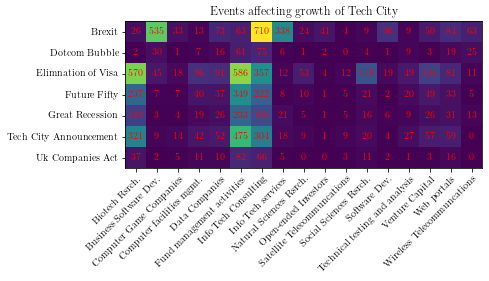

In [22]:
# add and minpulate my datta
events = np.array(event_df['sector_name_1'].unique())
sectors = np.array(event_df['event'].unique())

companies = np.array(event_df['count']).reshape(7, 17)

# create figure
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(121)
im = ax.imshow(companies, aspect='equal')

# we want to show all ticks...
ax.set_xticks(np.arange(len(events)))
ax.set_yticks(np.arange(len(sectors)))
# ... and label them with the respective list entries
ax.set_xticklabels(events)
ax.set_yticklabels(sectors)

# rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# loop over data dimensions and create text annotations.
for i in range(len(sectors)):
    for j in range(len(events)):
        text = ax.text(j,
                       i,
                       companies[i, j],
                       ha="center",
                       va="center",
                       color="red")

ax.set_title("Events affecting growth of Tech City")
f.tight_layout()

# save as png
file_path = os.path.join('output', 'events_sector_tech_city.png')
plt.savefig(file_path, dpi=400)
print(f"The html file is saved to {file_path}")

plt.show()